In [1]:
# Import required packages
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
from datetime import datetime, timedelta
import xarray as xr
import rasterio as rio
import rioxarray
import geopandas as gpd
import time
from glob import glob
import scipy.signal
from mintpy.utils import readfile, writefile, utils as ut, plot
from mintpy.cli import view, tsview, plot_network, plot_transection
from mintpy.view import prep_slice, plot_slice
from pathlib import Path
from typing import List, Union

In [2]:
def get_common_overlap(file_list: List[Union[str, Path]]) -> List[float]:
    """Get the common overlap of  a list of GeoTIFF files
    
    Arg:
        file_list: a list of GeoTIFF files
    
    Returns:
         [ulx, uly, lrx, lry], the upper-left x, upper-left y, lower-right x, and lower-right y
         corner coordinates of the common overlap
    """
    
    corners = [gdal.Info(str(dem), format='json')['cornerCoordinates'] for dem in file_list]

    ulx = max(corner['upperLeft'][0] for corner in corners)
    uly = min(corner['upperLeft'][1] for corner in corners)
    lrx = min(corner['lowerRight'][0] for corner in corners)
    lry = max(corner['lowerRight'][1] for corner in corners)
    return [ulx, uly, lrx, lry]

In [3]:
def clip_hyp3_products_to_common_overlap(data_path: Union[str, Path], overlap: List[float]) -> None:
    """Clip all GeoTIFF files to their common overlap
    
    Args:
        data_dir:
            directory containing the GeoTIFF files to clip
        overlap:
            a list of the upper-left x, upper-left y, lower-right-x, and lower-tight y
            corner coordinates of the common overlap
    Returns: None
    """
    
    files_for_mintpy = ['rng_off.tif', '_snr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif']

    for extension in files_for_mintpy:
        print(f'working on {extension}') 
        for file in data_path.rglob(f'*{extension}'):

            dst_file = file.parent / f'{file.stem}_notcorr_clipped{file.suffix}' #notcorr required to correctly load metadata 

            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)

In [ ]:
# # get overlap from aoi
# imja_region_fn = '../../../mapping/imja_region.shp'
# imja_region_gdf = gpd.read_file(imja_region_fn)

In [ ]:
# aoi_overlap = [imja_region_gdf.bounds.minx.item(),
#                imja_region_gdf.bounds.maxy.item(),
#                imja_region_gdf.bounds.maxx.item(),
#                imja_region_gdf.bounds.miny.item()]

In [4]:
mintpy_path = '/mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets'

In [5]:
data_path = '/mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/data_offsets'
phase_files = Path(data_path).glob('*/*/*_rng_off.tif')
overlap = get_common_overlap(phase_files)
clip_hyp3_products_to_common_overlap(Path(data_path), overlap)

/home/gbrench/sw/miniconda3/envs/mintpy/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


working on rng_off.tif
working on _snr.tif
working on _unw_phase.tif
working on _dem.tif
working on _lv_theta.tif
working on _lv_phi.tif


In [8]:
# Function to write to MintPy config file
def write_config_file(out_file, CONFIG_TXT, mode='a'): 
    """Write configuration files for MintPy to process products"""
    if not os.path.isfile(out_file) or mode == 'w':
        with open(out_file, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(out_file))
    else:
        with open(out_file, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(CONFIG_TXT))

In [17]:
CONFIG_TXT = f'''
# vim: set filetype=cfg:
##------------------------ smallbaselineApp.cfg ------------------------##
########## computing resource configuration
mintpy.compute.maxMemory = 10 #auto for 4, max memory to allocate in GB
## parallel processing with dask
## currently apply to steps: invert_network, correct_topography
## cluster   = none to turn off the parallel computing
## numWorker = all  to use all of locally available cores (for cluster = local only)
## numWorker = 80%  to use 80% of locally available cores (for cluster = local only)
## config    = none to rollback to the default name (same as the cluster type; for cluster != local)
mintpy.compute.cluster   = local #[local / slurm / pbs / lsf / none], auto for none, cluster type
mintpy.compute.numWorker = 4 #[int > 1 / all / num%], auto for 4 (local) or 40 (slurm / pbs / lsf), num of workers
mintpy.compute.config    = auto #[none / slurm / pbs / lsf ], auto for none (same as cluster), config name


########## 1. load_data
##---------add attributes manually
## MintPy requires attributes listed at: https://mintpy.readthedocs.io/en/latest/api/attributes/
## Missing attributes can be added below manually (uncomment #), e.g.
# ORBIT_DIRECTION = ascending
# PLATFORM = Sen
# ...
## a. autoPath - automatic path pattern defined in mintpy.defaults.auto_path.AUTO_PATH_*
## b. load_data.py -H to check more details and example inputs.
## c. compression to save disk usage for ifgramStack.h5 file:
## no   - save   0% disk usage, fast [default]
## lzf  - save ~57% disk usage, relative slow
## gzip - save ~62% disk usage, very slow [not recommend]
mintpy.load.processor       = hyp3 #[isce, aria, hyp3, gmtsar, snap, gamma, roipac, nisar], auto for isce
mintpy.load.autoPath        = auto  #[yes / no], auto for no, use pre-defined auto path
mintpy.load.updateMode      = auto  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
mintpy.load.compression     = auto  #[gzip / lzf / no], auto for no.
##---------interferogram stack:
mintpy.load.unwFile         = ../data_offsets/*/*/S1*rng_off_notcorr_clipped.tif  #[path pattern of unwrapped interferogram files]
mintpy.load.corFile         = ../data_offsets/*/*/S1*snr_notcorr_clipped.tif  #[path pattern of spatial coherence       files]
##---------geometry:
mintpy.load.demFile         = ../data_offsets/*/*/S1*dem_notcorr_clipped.tif   #[path of DEM file]
mintpy.load.incAngleFile    = ../data_offsets/*/*/S1*lv_notcorr_theta_clipped.tif   #[path of incidence angle file], optional but recommended
mintpy.load.azAngleFile     = ../data_offsets/*/*/S1*lv_notcorr_phi_clipped.tif   #[path of azimuth   angle file], optional
########## 2. modify_network
## 1) Network modification based on temporal/perpendicular baselines, date, num of connections etc.
mintpy.network.tempBaseMax     = auto  #[1-inf, no], auto for no, max temporal baseline in days
mintpy.network.perpBaseMax     = auto  #[1-inf, no], auto for no, max perpendicular spatial baseline in meter
mintpy.network.connNumMax      = auto  #[1-inf, no], auto for no, max number of neighbors for each acquisition
mintpy.network.startDate       = auto  #[20090101 / no], auto for no
mintpy.network.endDate         = auto  #[20110101 / no], auto for no
mintpy.network.excludeDate     = auto  #[20080520,20090817 / no], auto for no
mintpy.network.excludeIfgIndex = auto  #[1:5,25 / no], auto for no, list of ifg index (start from 0)
mintpy.network.referenceFile   = auto  #[date12_list.txt / ifgramStack.h5 / no], auto for no

## 2) Data-driven network modification
## a - Coherence-based network modification = (threshold + MST) by default
## reference: Yunjun et al. (2019, section 4.2 and 5.3.1); Chaussard et al. (2015, GRL)
## It calculates a average coherence for each interferogram using spatial coherence based on input mask (with AOI)
## Then it finds a minimum spanning tree (MST) network with inverse of average coherence as weight (keepMinSpanTree)
## Next it excludes interferograms if a) the average coherence < minCoherence AND b) not in the MST network.
mintpy.network.coherenceBased  = auto  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence
mintpy.network.minCoherence    = 0  #[0.0-1.0], auto for 0.7

## b - Effective Coherence Ratio network modification = (threshold + MST) by default
## reference: Kang et al. (2021, RSE)
## It calculates the area ratio of each interferogram that is above a spatial coherence threshold.
## This threshold is defined as the spatial coherence of the interferograms within the input mask.
## It then finds a minimum spanning tree (MST) network with inverse of the area ratio as weight (keepMinSpanTree)
## Next it excludes interferograms if a) the area ratio < minAreaRatio AND b) not in the MST network.
mintpy.network.areaRatioBased  = auto  #[yes / no], auto for no, exclude interferograms with area ratio < minAreaRatio
mintpy.network.minAreaRatio    = auto  #[0.0-1.0], auto for 0.75

## Additional common parameters for the 2) data-driven network modification
mintpy.network.keepMinSpanTree = yes  #[yes / no], auto for yes, keep interferograms in Min Span Tree network
mintpy.network.maskFile        = auto  #[file name, no], auto for waterMask.h5 or no [if no waterMask.h5 found]
mintpy.network.aoiYX           = auto  #[y0:y1,x0:x1 / no], auto for no, area of interest for coherence calculation
mintpy.network.aoiLALO         = auto #[S:N,W:E / no], auto for no - use the whole area


########## 3. reference_point
## Reference all interferograms to one common point in space
## auto - randomly select a pixel with coherence > minCoherence
## however, manually specify using prior knowledge of the study area is highly recommended
##   with the following guideline (section 4.3 in Yunjun et al., 2019):
## 1) located in a coherence area, to minimize the decorrelation effect.
## 2) not affected by strong atmospheric turbulence, i.e. ionospheric streaks
## 3) close to and with similar elevation as the AOI, to minimize the impact of spatially correlated atmospheric delay
mintpy.reference.yx            = auto   #[257,151 / auto]
mintpy.reference.lalo          = 3087261.5,489428.3 # 28.003585, 88.480191  #[31.8,130.8 / auto]
mintpy.reference.maskFile      = no   #[filename / no], auto for maskConnComp.h5
mintpy.reference.coherenceFile = no   #[filename], auto for avgSpatialCoh.h5
mintpy.reference.minCoherence  = 0   #[0.0-1.0], auto for 0.85, minimum coherence for auto method


########## quick_overview
## A quick assessment of:
## 1) possible groud deformation
##    using the velocity from the traditional interferogram stacking
##    reference: Zebker et al. (1997, JGR)
## 2) distribution of phase unwrapping error
##    from the number of interferogram triplets with non-zero integer ambiguity of closue phase
##    reference: T_int in Yunjun et al. (2019, CAGEO). Related to section 3.2, equation (8-9) and Fig. 3d-e.


########## 4. correct_unwrap_error (optional)
## connected components (mintpy.load.connCompFile) are required for this step.
## SNAPHU (Chem & Zebker,2001) is currently the only unwrapper that provides connected components as far as we know.
## reference: Yunjun et al. (2019, section 3)
## supported methods:
## a. phase_closure          - suitable for highly redundant network
## b. bridging               - suitable for regions separated by narrow decorrelated features, e.g. rivers, narrow water bodies
## c. bridging+phase_closure - recommended when there is a small percentage of errors left after bridging
mintpy.unwrapError.method          = no  #[bridging / phase_closure / bridging+phase_closure / no], auto for no
mintpy.unwrapError.waterMaskFile   = auto  #[waterMask.h5 / no], auto for waterMask.h5 or no [if not found]
mintpy.unwrapError.connCompMinArea = auto  #[1-inf], auto for 2.5e3, discard regions smaller than the min size in pixels

## phase_closure options:
## numSample - a region-based strategy is implemented to speedup L1-norm regularized least squares inversion.
##     Instead of inverting every pixel for the integer ambiguity, a common connected component mask is generated,
##     for each common conn. comp., numSample pixels are radomly selected for inversion, and the median value of the results
##     are used for all pixels within this common conn. comp.
mintpy.unwrapError.numSample       = auto  #[int>1], auto for 100, number of samples to invert for common conn. comp.

## bridging options:
## ramp - a phase ramp could be estimated based on the largest reliable region, removed from the entire interferogram
##     before estimating the phase difference between reliable regions and added back after the correction.
## bridgePtsRadius - half size of the window used to calculate the median value of phase difference
mintpy.unwrapError.ramp            = auto  #[linear / quadratic], auto for no; recommend linear for L-band data
mintpy.unwrapError.bridgePtsRadius = auto  #[1-inf], auto for 50, half size of the window around end points


########## 5. invert_network
## Invert network of interferograms into time-series using weighted least square (WLS) estimator.
## weighting options for least square inversion [fast option available but not best]:
## a. var - use inverse of covariance as weight (Tough et al., 1995; Guarnieri & Tebaldini, 2008) [recommended]
## b. fim - use Fisher Information Matrix as weight (Seymour & Cumming, 1994; Samiei-Esfahany et al., 2016).
## c. coh - use coherence as weight (Perissin & Wang, 2012)
## d. no  - uniform weight (Berardino et al., 2002) [fast]
## SBAS (Berardino et al., 2002) = minNormVelocity (yes) + weightFunc (no)
mintpy.networkInversion.weightFunc      = coh #[var / fim / coh / no], auto for var
mintpy.networkInversion.waterMaskFile   = auto #[filename / no], auto for waterMask.h5 or no [if not found]
mintpy.networkInversion.minNormVelocity = auto #[yes / no], auto for yes, min-norm deformation velocity / phase

## mask options for unwrapPhase of each interferogram before inversion (recommend if weightFunct=no):
## a. coherence              - mask out pixels with spatial coherence < maskThreshold
## b. connectComponent       - mask out pixels with False/0 value
## c. no                     - no masking [recommended].
## d. range/azimuthOffsetStd - mask out pixels with offset std. dev. > maskThreshold [for offset]
mintpy.networkInversion.maskDataset   = auto #[coherence / connectComponent / rangeOffsetStd / azimuthOffsetStd / no], auto for no
mintpy.networkInversion.maskThreshold = 0 #[0-inf], auto for 0.4
mintpy.networkInversion.minRedundancy = auto #[1-inf], auto for 1.0, min num_ifgram for every SAR acquisition

## Temporal coherence is calculated and used to generate the mask as the reliability measure
## reference: Pepe & Lanari (2006, IEEE-TGRS)
mintpy.networkInversion.minTempCoh  = 0.0 #[0.0-1.0], auto for 0.7, min temporal coherence for mask
mintpy.networkInversion.minNumPixel = auto #[int > 1], auto for 100, min number of pixels in mask above
mintpy.networkInversion.shadowMask  = no #[yes / no], auto for yes [if shadowMask is in geometry file] or no.

########## 6. correct_troposphere (optional but recommended)
## correct tropospheric delay using the following methods:
## a. height_correlation - correct stratified tropospheric delay (Doin et al., 2009, J Applied Geop)
## b. pyaps - use Global Atmospheric Models (GAMs) data (Jolivet et al., 2011; 2014)
##      ERA5  - ERA5    from ECMWF [need to install PyAPS from GitHub; recommended and turn ON by default]
##      MERRA - MERRA-2 from NASA  [need to install PyAPS from Caltech/EarthDef]
##      NARR  - NARR    from NOAA  [need to install PyAPS from Caltech/EarthDef; recommended for N America]
## c. gacos - use GACOS with the iterative tropospheric decomposition model (Yu et al., 2018, JGR)
##      need to manually download GACOS products at http://www.gacos.net for all acquisitions before running this step
mintpy.troposphericDelay.method = no  #[pyaps / height_correlation / gacos / no], auto for pyaps

## Notes for pyaps:
## a. GAM data latency: with the most recent SAR data, there will be GAM data missing, the correction
##    will be applied to dates with GAM data available and skipped for the others.
## b. WEATHER_DIR: if you define an environment variable named WEATHER_DIR to contain the path to a
##    directory, then MintPy applications will download the GAM files into the indicated directory.
##    MintPy application will look for the GAM files in the directory before downloading a new one to
##    prevent downloading multiple copies if you work with different dataset that cover the same date/time.
mintpy.troposphericDelay.weatherModel = auto  #[ERA5 / MERRA / NARR], auto for ERA5
mintpy.troposphericDelay.weatherDir   = auto  #[path2directory], auto for WEATHER_DIR or "./"

## Notes for height_correlation:
## Extra multilooking is applied to estimate the empirical phase/elevation ratio ONLY.
## For an dataset with 5 by 15 looks, looks=8 will generate phase with (5*8) by (15*8) looks
## to estimate the empirical parameter; then apply the correction to original phase (with 5 by 15 looks),
## if the phase/elevation correlation is larger than minCorrelation.
mintpy.troposphericDelay.polyOrder      = auto  #[1 / 2 / 3], auto for 1
mintpy.troposphericDelay.looks          = auto  #[1-inf], auto for 8, extra multilooking num
mintpy.troposphericDelay.minCorrelation = auto  #[0.0-1.0], auto for 0

## Notes for gacos:
## Set the path below to directory that contains the downloaded *.ztd* files
mintpy.troposphericDelay.gacosDir = auto # [path2directory], auto for "./GACOS"


########## 7. deramp (optional)
## Estimate and remove a phase ramp for each acquisition based on the reliable pixels.
## Recommended for localized deformation signals, i.e. volcanic deformation, landslide and land subsidence, etc.
## NOT recommended for long spatial wavelength deformation signals, i.e. co-, post- and inter-seimic deformation.
mintpy.deramp          = no  #[no / linear / quadratic], auto for no - no ramp will be removed
mintpy.deramp.maskFile = auto  #[filename / no], auto for maskTempCoh.h5, mask file for ramp estimation


########## 8. correct_topography (optional but recommended)
## Topographic residual (DEM error) correction
## reference: Fattahi and Amelung (2013, IEEE-TGRS)
## stepFuncDate      - specify stepFuncDate option if you know there are sudden displacement jump in your area,
##                     e.g. volcanic eruption, or earthquake
## excludeDate       - dates excluded for the error estimation
## pixelwiseGeometry - use pixel-wise geometry (incidence angle & slant range distance)
##                     yes - use pixel-wise geometry if they are available [slow; used by default]
##                     no  - use the mean   geometry [fast]
mintpy.topographicResidual                   = no  #[yes / no], auto for yes
mintpy.topographicResidual.polyOrder         = auto  #[1-inf], auto for 2, poly order of temporal deformation model
mintpy.topographicResidual.phaseVelocity     = auto  #[yes / no], auto for no - use phase velocity for minimization
mintpy.topographicResidual.stepFuncDate      = auto  #[20080529,20190704T1733 / no], auto for no, date of step jump
mintpy.topographicResidual.excludeDate       = auto  #[20070321 / txtFile / no], auto for exclude_date.txt
mintpy.topographicResidual.pixelwiseGeometry = auto  #[yes / no], auto for yes, use pixel-wise geometry info


########## 9.1 residual_RMS (root mean squares for noise evaluation)
## Calculate the Root Mean Square (RMS) of residual phase time-series for each acquisition
## reference: Yunjun et al. (2019, section 4.9 and 5.4)
## To get rid of long spatial wavelength component, a ramp is removed for each acquisition
## Set optimal reference date to date with min RMS
## Set exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)
mintpy.residualRMS.maskFile = auto  #[file name / no], auto for maskTempCoh.h5, mask for ramp estimation
mintpy.residualRMS.deramp   = auto  #[quadratic / linear / no], auto for quadratic
mintpy.residualRMS.cutoff   = auto  #[0.0-inf], auto for 3

########## 9.2 reference_date
## Reference all time-series to one date in time
## reference: Yunjun et al. (2019, section 4.9)
## no     - do not change the default reference date (1st date)
mintpy.reference.date = no   #[reference_date.txt / 20090214 / no], auto for reference_date.txt


########## 10. velocity
## Estimate a suite of time functions [linear velocity by default]
## from final displacement file (and from tropospheric delay file if exists)
mintpy.timeFunc.startDate   = auto   #[20070101 / no], auto for no
mintpy.timeFunc.endDate     = auto   #[20101230 / no], auto for no
mintpy.timeFunc.excludeDate = auto   #[exclude_date.txt / 20080520,20090817 / no], auto for exclude_date.txt

## Fit a suite of time functions
## reference: Hetland et al. (2012, JGR) equation (2-9)
## polynomial function    is  defined by its degree in integer. 1 for linear, 2 for quadratic, etc.
## periodic   function(s) are defined by a list of periods in decimal years. 1 for annual, 0.5 for semi-annual, etc.
## step       function(s) are defined by a list of onset times in str in YYYYMMDD(THHMM) format
## exp & log  function(s) are defined by an onset time followed by an charateristic time in integer days.
##   Multiple exp and log functions can be overlaied on top of each other, achieved via e.g.:
##   20110311,60,120          - two functions sharing the same onset time OR
##   20110311,60;20170908,120 - separated by ";"
mintpy.timeFunc.polynomial = auto   #[int >= 0], auto for 1, degree of the polynomial function
mintpy.timeFunc.periodic   = auto   #[1,0.5 / list_of_float / no], auto for no, periods in decimal years
mintpy.timeFunc.stepDate   = auto   #[20110311,20170908 / 20120928T1733 / no], auto for no, step function(s)
mintpy.timeFunc.exp        = auto   #[20110311,60 / 20110311,60,120 / 20110311,60;20170908,120 / no], auto for no
mintpy.timeFunc.log        = auto   #[20110311,60 / 20110311,60,120 / 20110311,60;20170908,120 / no], auto for no

## Uncertainty quantification methods:
## a. residue    - propagate from fitting residue assuming normal dist. in time (Fattahi & Amelung, 2015, JGR)
## b. covariance - propagate from time series (co)variance matrix
## c. bootstrap  - bootstrapping (independently resampling with replacement; Efron & Tibshirani, 1986, Stat. Sci.)
mintpy.timeFunc.uncertaintyQuantification = auto   #[residue, covariance, bootstrap], auto for residue
mintpy.timeFunc.timeSeriesCovFile         = auto   #[filename / no], auto for no, time series covariance file
mintpy.timeFunc.bootstrapCount            = auto   #[int>1], auto for 400, number of iterations for bootstrapping


########## 11.1 geocode (post-processing)
# for input dataset in radar coordinates only
# commonly used resolution in meters and in degrees (on equator)
# 100,         90,          60,          50,          40,          30,          20,          10
# 0.000925926, 0.000833334, 0.000555556, 0.000462963, 0.000370370, 0.000277778, 0.000185185, 0.000092593
mintpy.geocode              = no  #[yes / no], auto for yes
mintpy.geocode.SNWE         = auto  #[-1.2,0.5,-92,-91 / none ], auto for none, output extent in degree
mintpy.geocode.laloStep     = None  #[-0.000555556,0.000555556 / None], auto for None, output resolution in degree
mintpy.geocode.interpMethod = auto  #[linear], auto for nearest, interpolation method
mintpy.geocode.fillValue    = auto  #[np.nan, 0, ...], auto for np.nan, fill value for outliers.

########## 11.2 google_earth (post-processing)
mintpy.save.kmz             = auto   #[yes / no], auto for yes, save geocoded velocity to Google Earth KMZ file

########## 11.3 hdfeos5 (post-processing)
mintpy.save.hdfEos5         = auto   #[yes / no], auto for no, save time-series to HDF-EOS5 format
mintpy.save.hdfEos5.update  = auto   #[yes / no], auto for no, put XXXXXXXX as endDate in output filename
mintpy.save.hdfEos5.subset  = auto   #[yes / no], auto for no, put subset range info   in output filename

########## 11.4 plot
# for high-resolution plotting, increase mintpy.plot.maxMemory
# for fast plotting with more parallelization, decrease mintpy.plot.maxMemory
mintpy.plot           = auto  #[yes / no], auto for yes, plot files generated by default processing to pic folder
mintpy.plot.dpi       = auto  #[int], auto for 150, number of dots per inch (DPI)
mintpy.plot.maxMemory = auto  #[float], auto for 4, max memory used by one call of view.py for plotting.
'''

In [18]:
os.chdir(mintpy_path)
config_file = f'{mintpy_path}/SenAT12.txt'
write_config_file(config_file, CONFIG_TXT, mode='w')

write configuration to file: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/SenAT12.txt


In [10]:
!smallbaselineApp.py SenAT12.txt --dostep load_data

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-02-02 10:57:31.394700--
Current directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SenAT12
Go to work directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
read custom template file: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/SenAT12.txt
update default template based on input custom template
    mintpy.load.unwFile: ../data_offsets/*/*/S1*rng_off_clipped.tif --> ../data_offsets/*/*/S1*rng_off_notcorr_

view.py inputs/ifgramStack.h5 unwrapPhase-* -v -10 10 --zero-mask --noaxis --noverbose


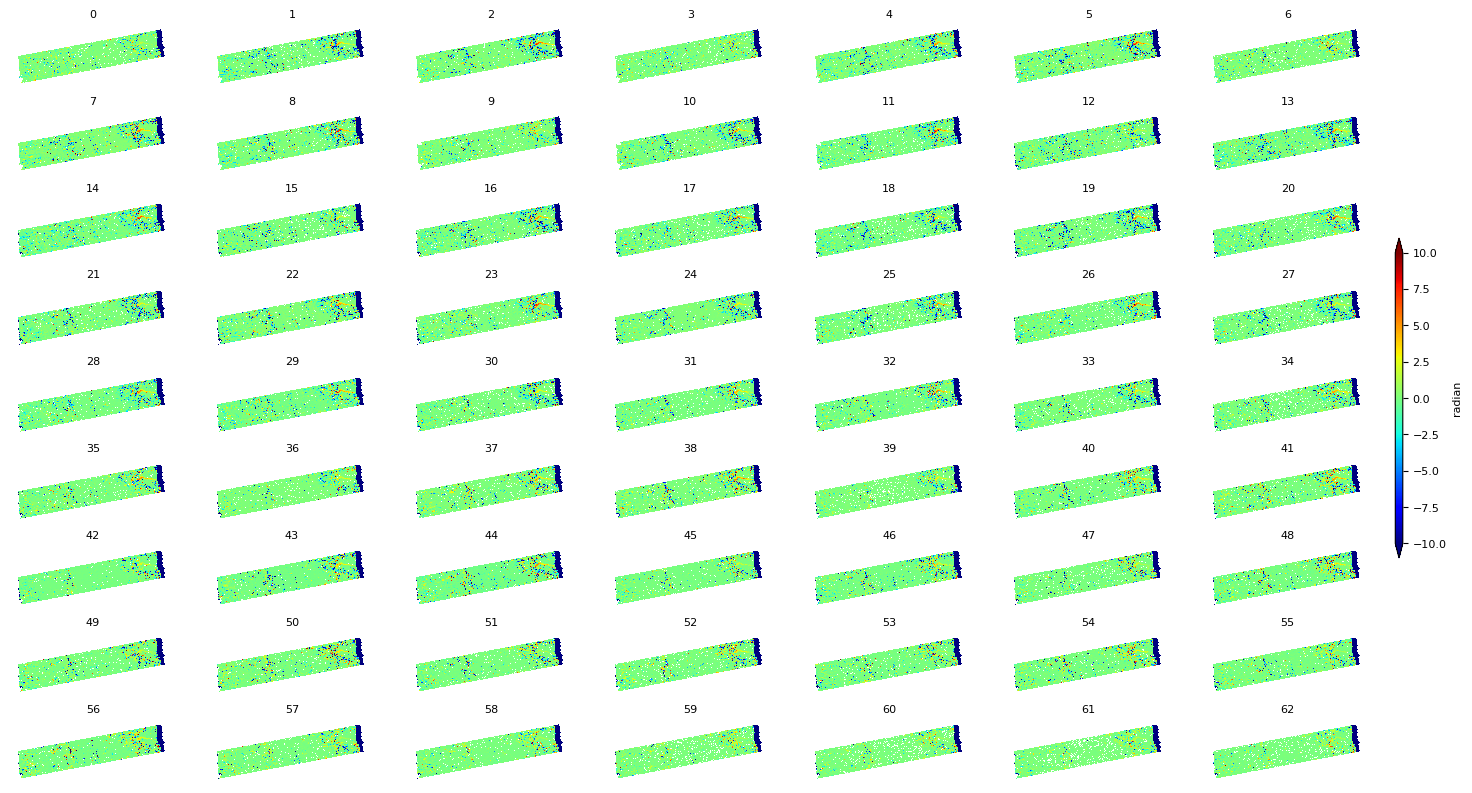

In [11]:
view.main('inputs/ifgramStack.h5 unwrapPhase-* -v -10 10 --zero-mask --noaxis --noverbose'.split())

In [12]:
!smallbaselineApp.py SenAT12.txt --dostep modify_network

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-02-02 10:59:56.943875--
Current directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SenAT12
Go to work directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
read custom template file: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/SenAT12.txt
update default template based on input custom template
No new option value found, skip updating /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/

read options from template file: smallbaselineApp.cfg
read temporal/spatial baseline info from file: inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 33
number of interferograms: 63
shift all perp baseline by 0.4981614351272583 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 63
number of acquisitions marked as drop: 0
max perpendicular baseline: 179.92 m
max temporal      baseline: 228.0 days
showing coherence
data range: [8.6298, 19.113]
display range: (0.2, 1.0)
showing ...


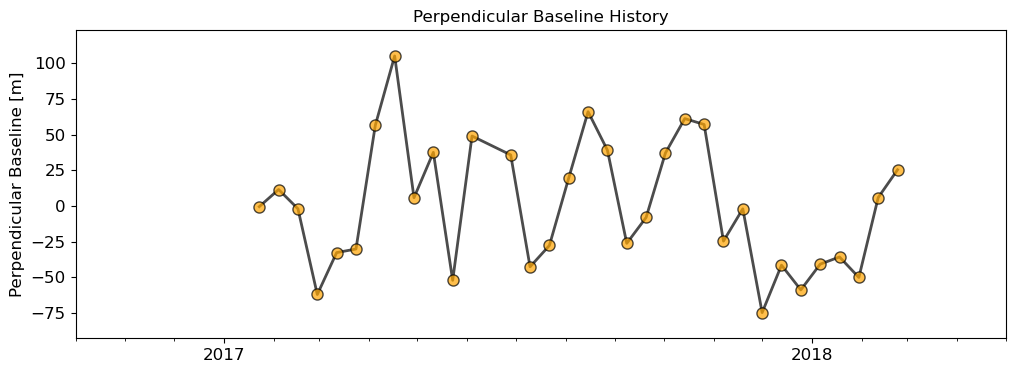

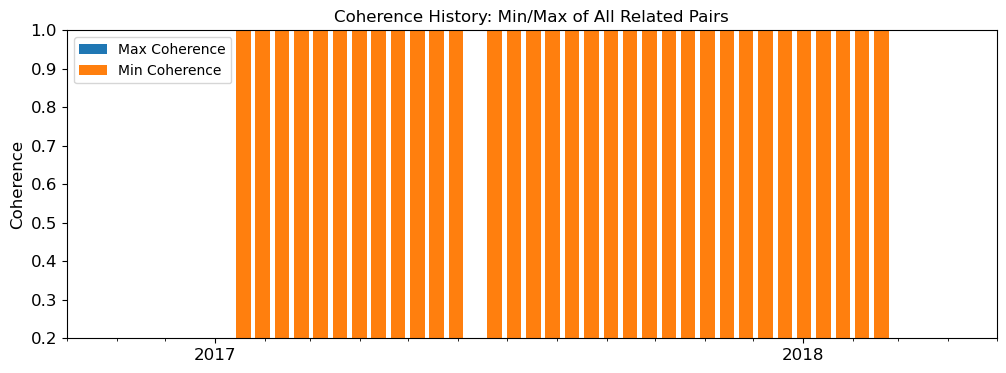

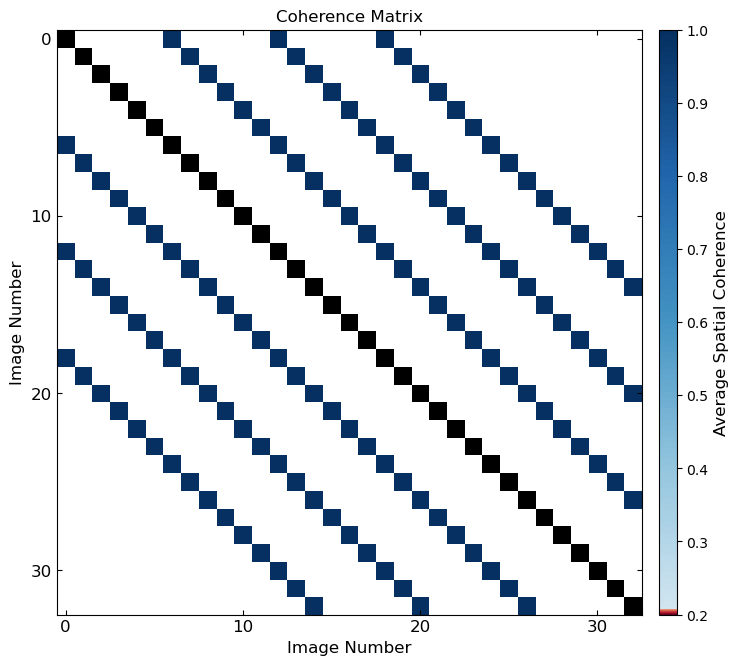

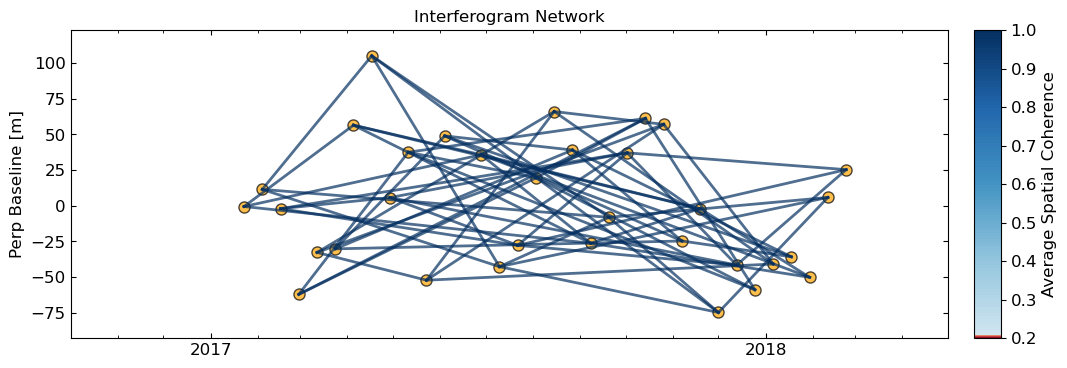

In [13]:
plot_network.main('inputs/ifgramStack.h5 -t smallbaselineApp.cfg --figsize 12 4'.split())

In [19]:
!smallbaselineApp.py SenAT12.txt --dostep reference_point

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-02-02 11:03:32.694174--
Current directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SenAT12
Go to work directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
read custom template file: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/SenAT12.txt
update default template based on input custom template
    mintpy.reference.maskFile: auto --> no
    mintpy.reference.coherenceFile: auto --> no
copy SenAT12.txt          to inputs   directory for

view.py maskConnComp.h5 -c gray --noverbose


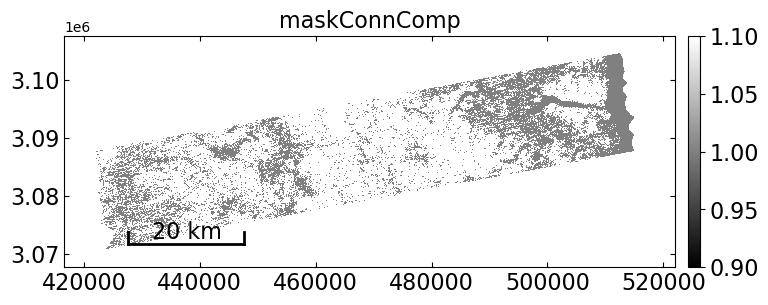

In [15]:
view.main('maskConnComp.h5 -c gray --noverbose'.split())

In [20]:
!smallbaselineApp.py SenAT12.txt --dostep quick_overview

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-02-02 11:03:52.029063--
Current directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
Run routine processing with smallbaselineApp.py on steps: ['quick_overview']
Remaining steps: ['correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SenAT12
Go to work directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
read custom template file: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/SenAT12.txt
update default template based on input custom template
No new option value found, skip updating /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/smallbaselineApp.cfg
copy SenAT12.txt

plot and save figure to file numTriNonzeroIntAmbiguity.png


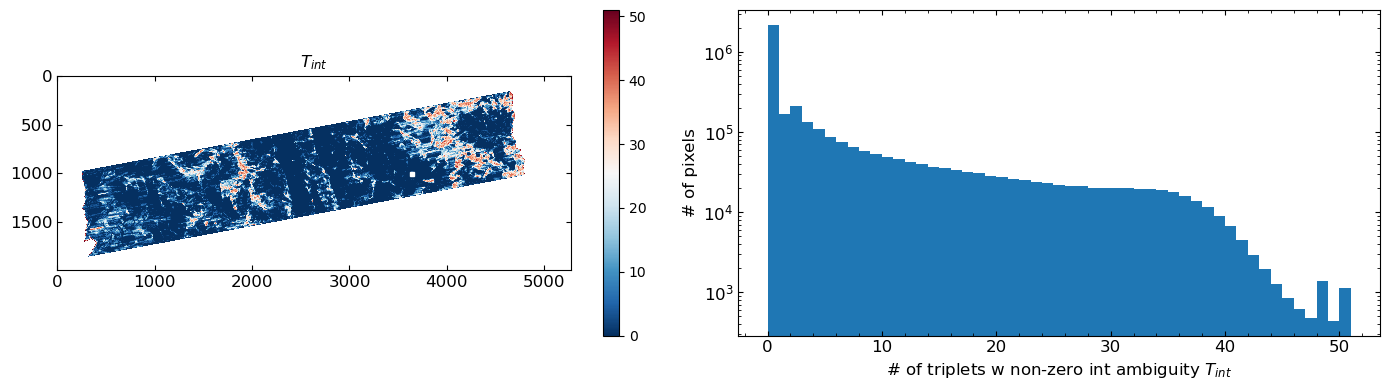

In [21]:
plot.plot_num_triplet_with_nonzero_integer_ambiguity('numTriNonzeroIntAmbiguity.h5', disp_fig=True, fig_size=[14, 4])

In [22]:
!smallbaselineApp.py SenAT12.txt --dostep correct_unwrap_error

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-02-02 11:04:29.051188--
Current directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
Run routine processing with smallbaselineApp.py on steps: ['correct_unwrap_error']
Remaining steps: ['invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SenAT12
Go to work directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
read custom template file: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/SenAT12.txt
update default template based on input custom template
No new option value found, skip updating /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/smallbaselineApp.cfg
copy SenAT12.txt          to input

In [23]:
!smallbaselineApp.py SenAT12.txt --dostep invert_network

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-02-02 11:04:36.012981--
Current directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SenAT12
Go to work directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
read custom template file: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/SenAT12.txt
update default template based on input custom template
No new option value found, skip updating /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/smallbaselineApp.cfg
copy SenAT12.txt          to inputs   directory for backup

view.py avgSpatialCoh.h5 --noverbose


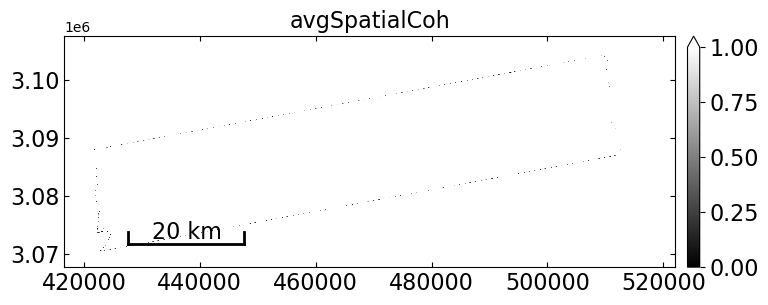

view.py temporalCoherence.h5 --noverbose


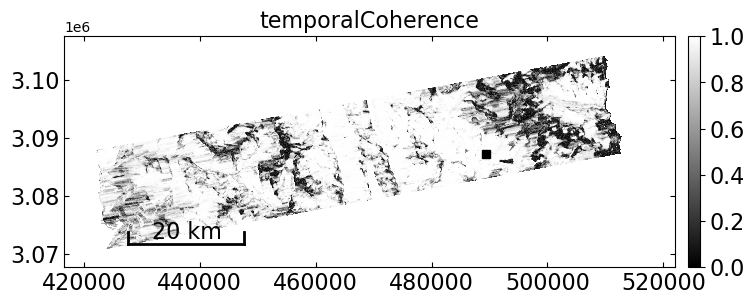

In [24]:
view.main('avgSpatialCoh.h5 --noverbose'.split())
view.main('temporalCoherence.h5 --noverbose'.split())

run view.py in MintPy version 1.5.3, date 2023-11-23
input file is timeseries file: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/timeseries.h5 in float32 format
file size in y/x: (1993, 5272)
num of datasets in file timeseries.h5: 33
datasets to exclude (0):
[]
datasets to display (33):
['timeseries-20170123', 'timeseries-20170204', 'timeseries-20170216', 'timeseries-20170228', 'timeseries-20170312', 'timeseries-20170324', 'timeseries-20170405', 'timeseries-20170417', 'timeseries-20170429', 'timeseries-20170511', 'timeseries-20170523', 'timeseries-20170604', 'timeseries-20170628', 'timeseries-20170710', 'timeseries-20170722', 'timeseries-20170803', 'timeseries-20170815', 'timeseries-20170827', 'timeseries-20170908', 'timeseries-20170920', 'timeseries-20171002', 'timeseries-20171014', 'timeseries-20171026', 'timeseries-20171107', 'timeseries-20171119', 'timeseries-20171201', 'timeseries-20171213', 'timeseries-20171225', 'timeseries-20180106', 'times

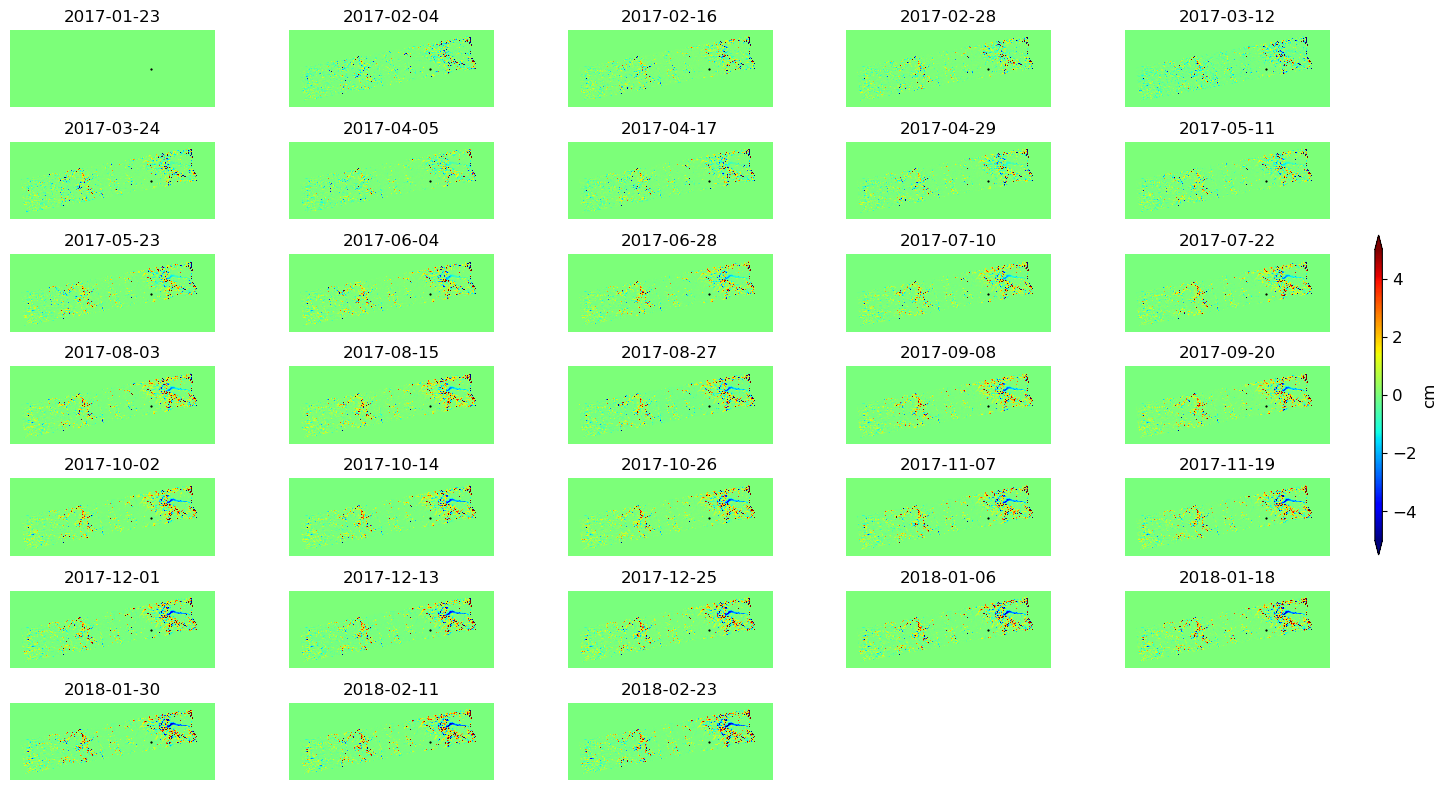

In [25]:
view.main('timeseries.h5 -v -5 5 --noaxis'.split())
# equivalent command in terminal: view.py timeseries.h5 -v -5 5 --noaxis

In [26]:
!smallbaselineApp.py SenAT12.txt --dostep deramp

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-02-02 11:15:29.939994--
Current directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SenAT12
Go to work directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
read custom template file: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/SenAT12.txt
update default template based on input custom template
No new option value found, skip updating /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/smallbaselineApp.cfg
copy SenAT12.txt          to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
copy SenA

In [27]:
!smallbaselineApp.py SenAT12.txt --dostep correct_topography

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-02-02 11:15:34.500187--
Current directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SenAT12
Go to work directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
read custom template file: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/SenAT12.txt
update default template based on input custom template
No new option value found, skip updating /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/smallbaselineApp.cfg
copy SenAT12.txt          to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
copy SenAT12.txt   

In [28]:
!smallbaselineApp.py SenAT12.txt --dostep residual_RMS

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-02-02 11:15:37.162210--
Current directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
Run routine processing with smallbaselineApp.py on steps: ['residual_RMS']
Remaining steps: ['reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SenAT12
Go to work directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
read custom template file: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/SenAT12.txt
update default template based on input custom template
No new option value found, skip updating /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/smallbaselineApp.cfg
copy SenAT12.txt          to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
copy SenAT12.txt          to pic      dir

In [29]:
!smallbaselineApp.py SenAT12.txt --dostep reference_date

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-02-02 11:15:40.432024--
Current directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
Run routine processing with smallbaselineApp.py on steps: ['reference_date']
Remaining steps: ['velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SenAT12
Go to work directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
read custom template file: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/SenAT12.txt
update default template based on input custom template
No new option value found, skip updating /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/smallbaselineApp.cfg
copy SenAT12.txt          to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
copy SenAT12.txt          to pic      directory for backu

In [30]:
!smallbaselineApp.py SenAT12.txt --dostep velocity

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-02-02 11:15:42.847494--
Current directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SenAT12
Go to work directory: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets
read custom template file: /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/SenAT12.txt
update default template based on input custom template
No new option value found, skip updating /mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_offsets/smallbaselineApp.cfg
copy SenAT12.txt          to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
copy SenAT12.txt          to pic      directory for backup.
copy smallbasel

view.py velocity.h5 --noverbose --vlim -0.02 0.02 -c RdBu


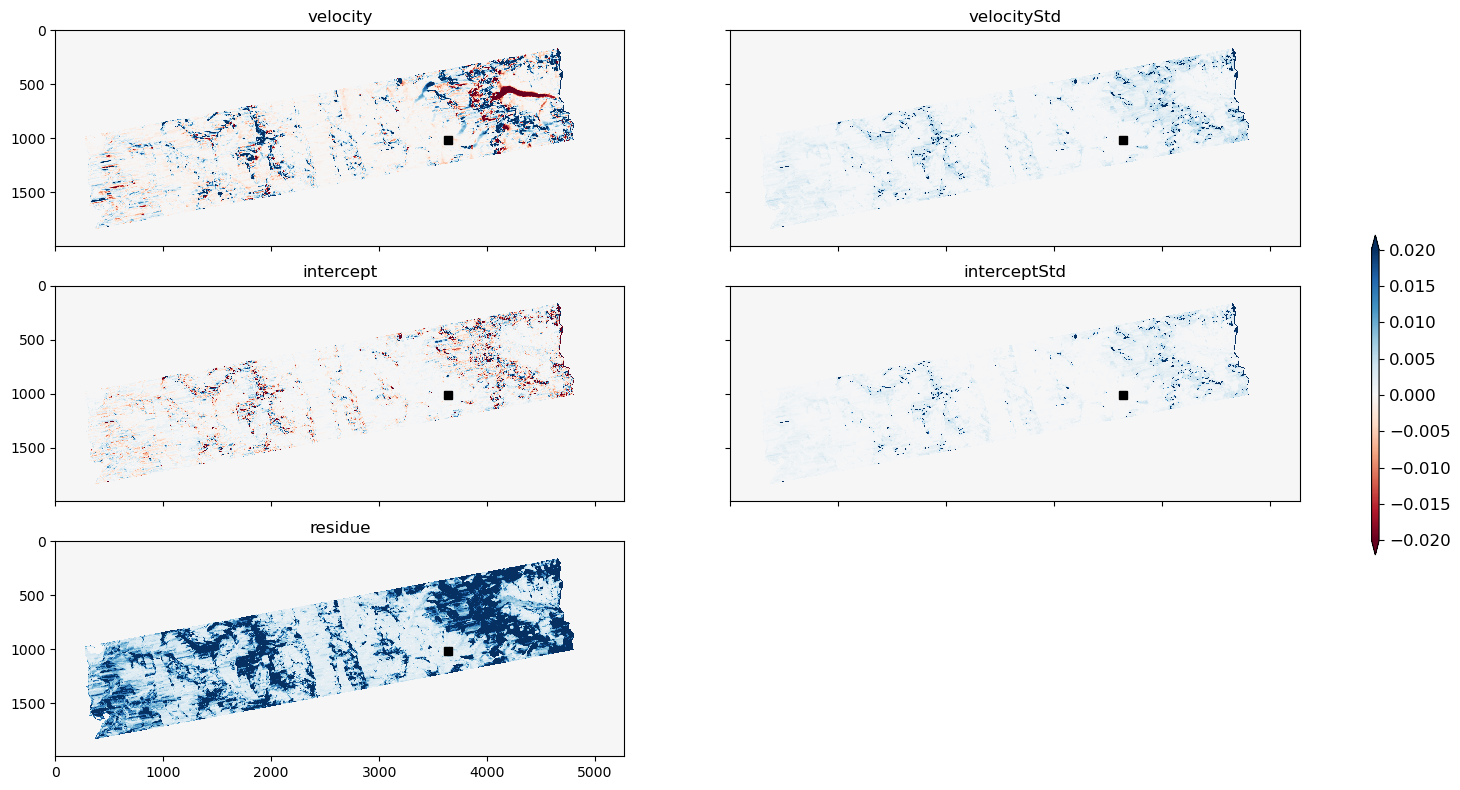

In [34]:
view.main('velocity.h5 --noverbose --vlim -0.02 0.02 -c RdBu'.split())